In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from sklearn.model_selection import GroupShuffleSplit
import json
import os
import random
from utils import (
    seq2onehot,
    DataGenerator,
    alphabet,
    plot_history,
    get_true_predicted_energies,
    compute_rmse,
    compute_pearsonr,
    plot_errors
)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Set all random seeds for reproducibility
def set_seeds(seed=5):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
set_seeds()

# Contents
 - [Load data](#load-data) 
 - [Data generator](#Data-generator)
 - [LSTM models](#lstm-models)
 - [Training](#training)
 - [Error analysis](#error-analysis)
 

## Load data

To test that the models can generalize to unseen proteins, the training and test are split such that they contain completely different protein wild types (pdbid).

In [3]:
df = pd.read_csv("mega_scale_ddg_single_mut_with_seq_no_con.csv")

# Train test split by pdbid
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['pdbid'])
train_inds, test_inds = next(split)

df_train = df.iloc[train_inds]
df_test = df.iloc[test_inds]

## Data generator

Below we define the data generator used for training. 

It generates the one-hot sequences of a batch of proteins, a one-hot mutation and the $\Delta\Delta G$ scores. 

For the wildtype amino acid, we use put a -1 in the one-hot vector of the mutant amino acid, this is an anti-symmetric vector with respect to reversal of the mutant and wildtype amino acid.

In [4]:
# We'll just use a typical batch size due to time constraints
batch_size = 64

# For the anti-symmetric LSTM we will need return_mutant=True
# For the non anti-symmetric LSTM, use return_mutant=False
train_gen = DataGenerator(df_train, batch_size, return_mutant=True)
test_gen = DataGenerator(df_test, batch_size, return_mutant=True, shuffle=False)

In [6]:
# Example one-hot sequence and score, looks at first 5 amino acids
(seq, mutant), score = train_gen.__getitem__(99)
print("sequence:", seq[0][:5,:])
print("mutant amino acid:",mutant[0,:])
print("score:",score[0])

sequence: <tf.RaggedTensor [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]>
mutant amino acid: tf.Tensor([ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0], shape=(20,), dtype=int32)
score: tf.Tensor(-0.160914823160823, shape=(), dtype=float64)


## LSTM models

* We will be using Long Short Term Memory (LSTM) neural networks, which have
been proven to work well at encoding and making predictions on sequence data. 
* A LSTM can remember information over a wide range of intervals throughout the sequence, this
is important since the protein structure (and therefore $\Delta\Delta G$) depends on short and long
range electrostatic interactions.
* It's best to start with simpler smaller models so that we have less assumptions about the model, meaning their more likely to generalize.
* We will start with a simple LSTM model, and then we will try to aid anti-symmetry by doing an elementwise multiplication of the mutant
amino acid with the output of the first dense layer (with no bias).
* We could also use antisymmetric activation functions (e.g. tanh) and no bias on the LSTM cells to further aid
anti-symmetry, but for some reason the models train a lot slower, so we ended up not
doing that.

In [7]:
def lstm_model(encoding_dim=100, dropout_rate=0.2):
    """Non anti-symmetric LSTM model"""

    # Inputs
    input_seq = Input(shape=(None, len(alphabet)))

    # Layers
    out_seq = LSTM(encoding_dim, dropout=dropout_rate)(input_seq)
    out = Dense(20)(out_seq)
    out = Dense(1, use_bias=False)(out)

    return Model(inputs=input_seq, outputs=out)

def lstm_antisym_model(encoding_dim=100, dropout_rate=0.2):
    """Anti-symmetric LSTM model"""

    # Inputs
    input_seq = Input(shape=(None, len(alphabet)))
    input_mutation = Input(shape=(len(alphabet)))

    # Layers
    out_seq = LSTM(encoding_dim, dropout=dropout_rate)(input_seq)
    out_seq = Dense(20)(out_seq)
    out = input_mutation * out_seq
    out = Dense(1, use_bias=False)(out)

    return Model(inputs=(input_seq, input_mutation), outputs=out)

# Choose the model to train
# model = lstm_model()
model = lstm_antisym_model()

In [8]:
# We'll use typical optimizers due to time constraint
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

## Training

To start off, we train the model using typical hyperparameters with 64 batch size, 0.001 learning rate, 20 epochs

In [9]:
# Make directories and save models every epoch
output_dir = "outputs/lstm_antisym"
os.makedirs(output_dir, exist_ok=True)

checkpoint_filepath = os.path.join(output_dir, "checkpoints", "cp-{epoch:04d}.ckpt")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",
)

In [ ]:
### Train the model, takes aprrox 2 hours so commented out###
### We can load the models below instead ###

############ 
# Train model
# history = model.fit(
#     x=train_gen,
#     steps_per_epoch=len(df_train) // batch_size + 1,
#     validation_data=test_gen,
#     validation_steps=len(df_test) // batch_size + 1,
#     epochs=20,
#     callbacks=[model_checkpoint_callback],
# )

# Save training history
# with open(os.path.join(output_dir, "history.json"), "w") as fp:
#     json.dump(history.history, fp)
############

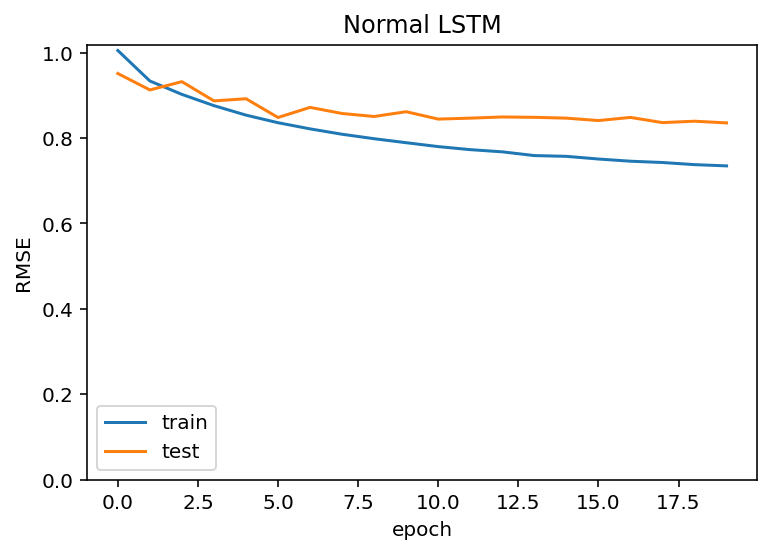

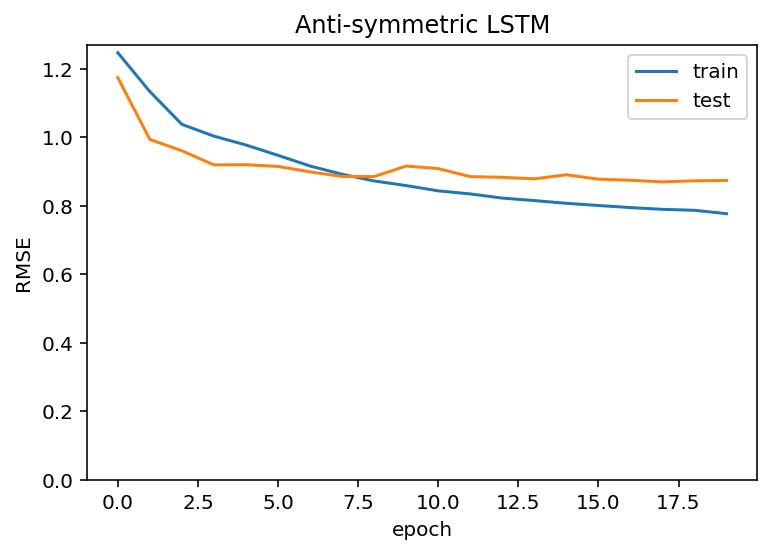

In [10]:
# Plot the histories for training
with open(os.path.join("outputs/lstm", "history.json"), "r") as fp:
    history = json.load(fp)
    plot_history(history,"Normal LSTM")
    
with open(os.path.join("outputs/lstm_antisym", "history.json"), "r") as fp:
    history = json.load(fp)
    plot_history(history,"Anti-symmetric LSTM")


In [11]:
### Load model since training takes 2 hours

model_lstm = tf.keras.models.load_model("outputs/lstm/checkpoints/cp-0020.ckpt") # load NON anti-symmetric model
model_lstm_antisym = tf.keras.models.load_model("outputs/lstm_antisym/checkpoints/cp-0020.ckpt") # load anti-symmetric model
model_lstm_antisym.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 20)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 100)          48400       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           2020        ['lstm[0][0]']                   
                                                                                              

## Error analysis

To test robustness, we'll use our models to predict direct and reverse mutations.

Results are shown on true vs. predicted plots below for each model

In [14]:
def get_results(model, test_gen, antisym=False):
    """Gets the predictions for the given model and plots them"""

    # Get true and predicted energies for the lstm model
    true_energies, pred_energies = get_true_predicted_energies(
        model, test_gen, batch_size, antisym=antisym
    )
    true_energies_reverse, pred_energies_reverse = get_true_predicted_energies(
        model, test_gen, batch_size, antisym=antisym, reverse=True
    )

    # Get RMSE and pearson correlation co-efficients
    rmse = compute_rmse(true_energies, pred_energies)
    rmse_reverse = compute_rmse(true_energies_reverse, pred_energies_reverse)

    pearsonr = compute_pearsonr(true_energies, pred_energies)
    pearsonr_reverse = compute_pearsonr(true_energies_reverse, pred_energies_reverse)

    # Plot results for direct and reverse mutations
    plot_errors(true_energies,
                pred_energies,
                rmse,
                pearsonr,
                true_label="True $\Delta\Delta G$",
                pred_label="Predicted $\Delta\Delta G$",
                savefile="plots/lstmanti_error")

    plot_errors(true_energies_reverse,
                pred_energies_reverse,
                rmse_reverse,
                pearsonr_reverse,
                true_label="True $\minus\Delta\Delta G$",
                pred_label="Predicted $\minus\Delta\Delta G$",
                savefile="plots/lstmanti_error_reverse")

The non-antisymmetric model has an okay pearson correlation, but their is no correlation for the reverse predictions

100%|██████████| 1101/1101 [01:25<00:00, 12.87it/s]


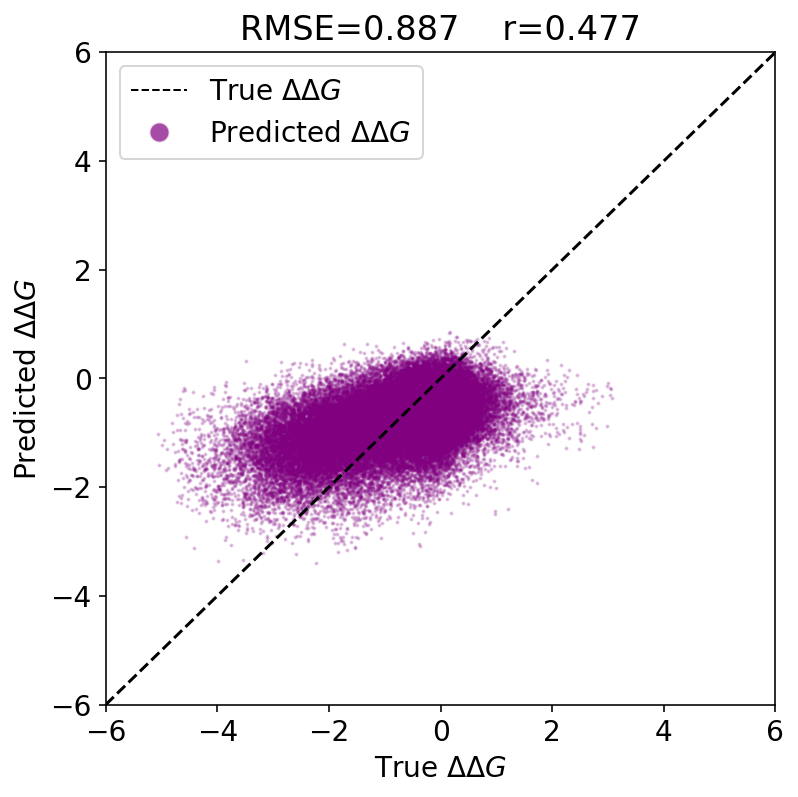

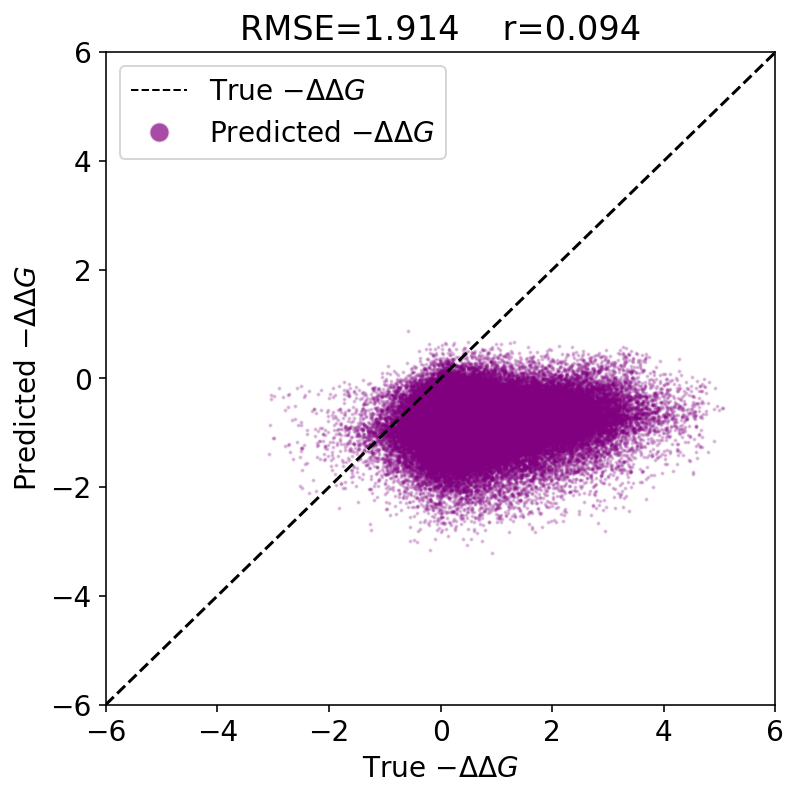

In [15]:
# Non-anti-symmetric model
get_results(model_lstm, test_gen)

The antisymmetric model has an okay pearson correlation, and slightly better correlation for the reverse predictions

100%|██████████| 1101/1101 [01:26<00:00, 12.80it/s]


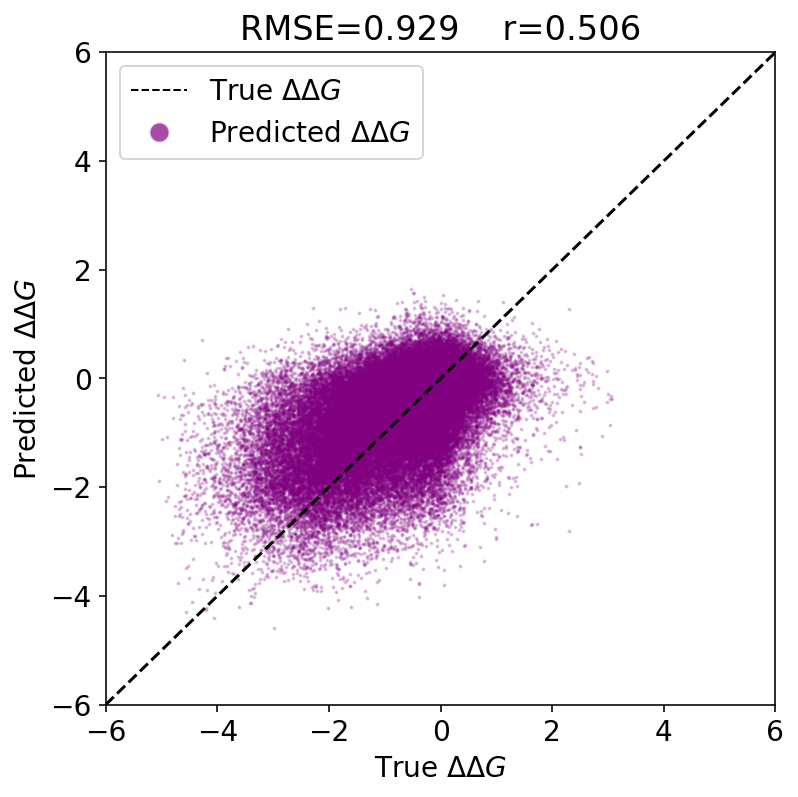

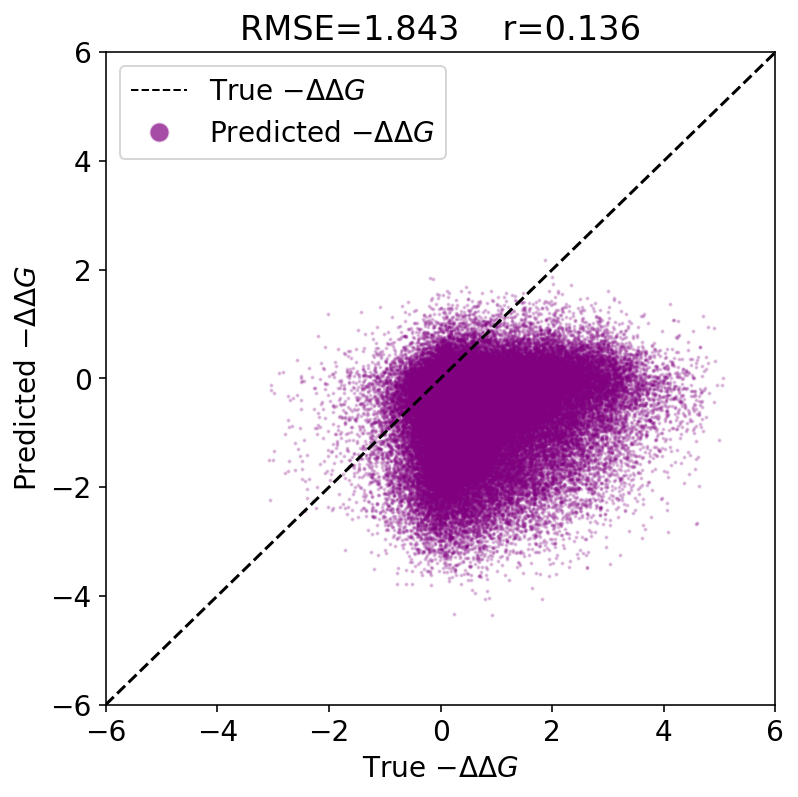

In [17]:
# Anti-symmetric model
get_results(model_lstm_antisym, test_gen, antisym=True)